# Denoising (DAE)

## Introduction

## 0. Imports & variables

In [1]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_images_from_folder(folder_path):
    images = []
    for filename in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append((filename, img))
    return images

original_images = load_images_from_folder('./processed_data/photos/')

  0%|          | 0/29979 [00:00<?, ?it/s]

In [4]:
import numpy as np

def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

def add_gaussian_noise(images, mean=0, sigma=25):
    clear_folder('./sducesinoisy/')
    for filename, img in tqdm(images):
        row, col, ch = img.shape
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        noisy = np.clip(img + gauss, 0, 255).astype(np.uint8)
        noisy_filename = "noisy_" + filename
        cv2.imwrite('./sducesinoisy/' + noisy_filename, noisy)

add_gaussian_noise(original_images)

  0%|          | 0/29979 [00:00<?, ?it/s]

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

def load_and_normalize_from_directory(directory, batch_size=128, img_size=(152, 152), validation_split=None, subset=None):
    dataset = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode=None,  # Aucun label car nous construisons un autoencoder
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=123,
        validation_split=validation_split,
        subset=subset
    )
    
    dataset = dataset.map(lambda x: x / 255.0, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [6]:
originals_train = load_and_normalize_from_directory('./processed_data/photos/', validation_split=0.1, subset='training')
originals_val = load_and_normalize_from_directory('./processed_data/photos/', validation_split=0.1, subset='validation')
noisies_train = load_and_normalize_from_directory('./sducesinoisy/', validation_split=0.1, subset='training')
noisies_val = load_and_normalize_from_directory('./sducesinoisy/', validation_split=0.1, subset='validation')

Found 29979 files belonging to 1 classes.
Using 26982 files for training.
Found 29979 files belonging to 1 classes.
Using 2997 files for validation.
Found 29979 files belonging to 1 classes.
Using 26982 files for training.
Found 29979 files belonging to 1 classes.
Using 2997 files for validation.


In [7]:
def combine_datasets(dataset1, dataset2):
    combined_dataset = tf.data.Dataset.zip((dataset1, dataset2))
    return combined_dataset

train_dataset = combine_datasets(noisies_train, originals_train)
val_dataset = combine_datasets(noisies_val, originals_val)

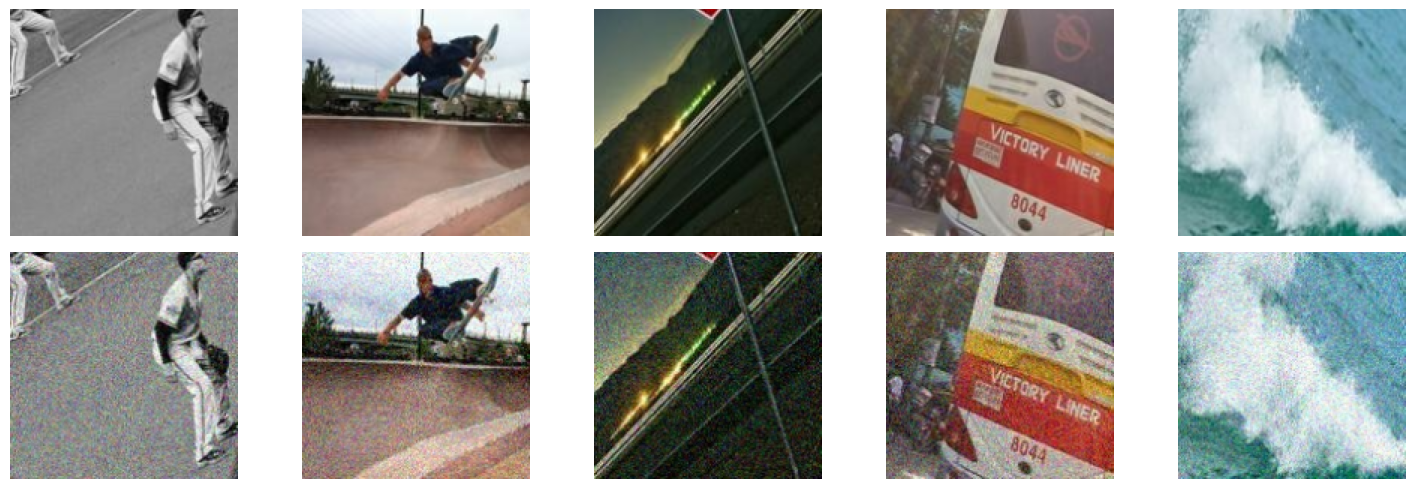

In [8]:
def display_pairs(originals, noisies, num_samples=5):
    # Prendre les num_samples premières images de chaque dataset
    originals_samples = [img[0].numpy() for img in originals.take(num_samples)]
    noisies_samples = [img[0].numpy() for img in noisies.take(num_samples)]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[0, i].imshow(originals_samples[i])
        axes[1, i].imshow(noisies_samples[i])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()
    
display_pairs(originals_train, noisies_train)

In [9]:
dae = None
with tf.device('/GPU:0'):
    input_shape = (152, 152, 3)

    encoder = Sequential()
    encoder.add(Input(shape=input_shape))
    encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))   

    decoder = Sequential()
    decoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  

    dae = Sequential([encoder, decoder])
    dae.compile(optimizer='adam', loss='binary_crossentropy')
    dae.build((None, 152, 152, 3))
    dae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 19, 19, 128)       93248     
                                                                 
 sequential_1 (Sequential)   (None, 152, 152, 3)       240707    
                                                                 
Total params: 333,955
Trainable params: 333,955
Non-trainable params: 0
_________________________________________________________________


In [10]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/dae/" + date
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
#tensorboard --logdir logs/fit/dae --bind_all

model_checkpoint_directory = f"weights/dae/{date}/"
os.makedirs(model_checkpoint_directory, exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

with tf.device('/GPU:0'):
    dae.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/20
211/211 [==============================] - 58s 238ms/step - loss: 0.5498 - val_loss: 0.5255
Epoch 2/20
211/211 [==============================] - 46s 214ms/step - loss: 0.5281 - val_loss: 0.5218
Epoch 3/20
211/211 [==============================] - 46s 214ms/step - loss: 0.5256 - val_loss: 0.5202
Epoch 4/20
211/211 [==============================] - 46s 214ms/step - loss: 0.5246 - val_loss: 0.5198
Epoch 5/20
211/211 [==============================] - 46s 214ms/step - loss: 0.5236 - val_loss: 0.5184
Epoch 6/20
211/211 [==============================] - 46s 214ms/step - loss: 0.5228 - val_loss: 0.5179
Epoch 7/20
211/211 [==============================] - 46s 214ms/step - loss: 0.5222 - val_loss: 0.5174
Epoch 8/20
211/211 [==============================] - 46s 215ms/step - loss: 0.5216 - val_loss: 0.5171
Epoch 9/20
211/211 [==============================] - 46s 215ms/step - loss: 0.5212 - val_loss: 0.5170
Epoch 10/20
211/211 [==============================] - 46s 214ms/step - l

In [12]:
def evaluate_model(model, test_dataset):
    loss = model.evaluate(test_dataset)
    print(f"Model Loss: {loss}")
evaluate_model(dae, val_dataset)

24/24 [==============================] - 3s 78ms/step - loss: 0.5144
Model Loss: 0.5144420862197876


In [11]:
import os
import pandas as pd

def load_data_into_dataframe(path):
    filenames = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    df = pd.DataFrame({'filename': filenames})
    return df

path = "./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/"
df = load_data_into_dataframe(path)

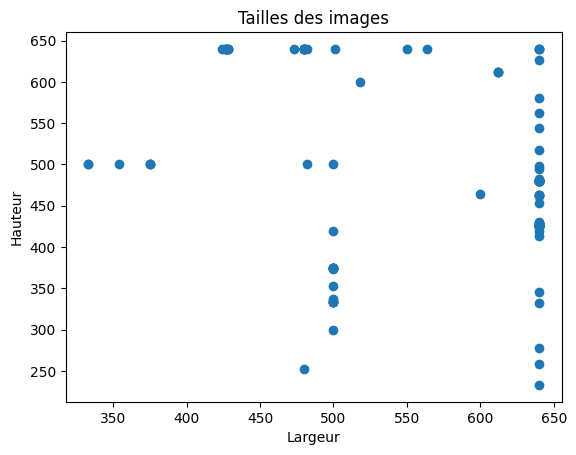

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_image_sizes(df):
    sizes = [Image.open(f).size for f in df['filename']]
    widths, heights = zip(*sizes)
    
    plt.scatter(widths, heights)
    plt.xlabel('Largeur')
    plt.ylabel('Hauteur')
    plt.title('Tailles des images')
    plt.show()

plot_image_sizes(df)

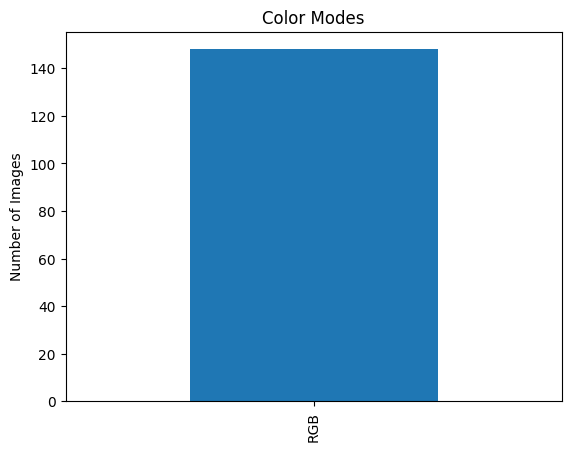

In [13]:
def plot_color_modes(df):
    color_modes = [Image.open(f).mode for f in df['filename']]
    mode_counts = pd.Series(color_modes).value_counts()

    mode_counts.plot(kind='bar')
    plt.title('Color Modes')
    plt.ylabel('Number of Images')
    plt.show()

plot_color_modes(df)

In [18]:
test_dataset = load_and_normalize_from_directory('./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/')

Found 148 files belonging to 1 classes.


In [13]:
def display_before_after(model, noisies):
    preds = model.predict(noisies[:5])
    fig, axes = plt.subplots(5, 2, figsize=(10, 10))
    for i in range(5):
        axes[i, 0].imshow(noisies[i])
        axes[i, 1].imshow(preds[i])
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    plt.show()

In [15]:
display_before_after(dae, noisies_train.take(1))

TypeError: 'TakeDataset' object is not subscriptable

## 3. Pré-processing

In [14]:
import tensorflow as tf

def load_and_preprocess_images(df, target_size=(152, 152)):
    # Charger les images
    images = [tf.io.read_file(f) for f in df['filename']]
    images = [tf.image.decode_image(img) for img in images]
    
    # Pré-traitement des images
    images = [tf.image.resize(img, target_size) for img in images]
    images = [tf.cast(img, tf.float32) / 255.0 for img in images]
    
    return images

processed_images = load_and_preprocess_images(df)

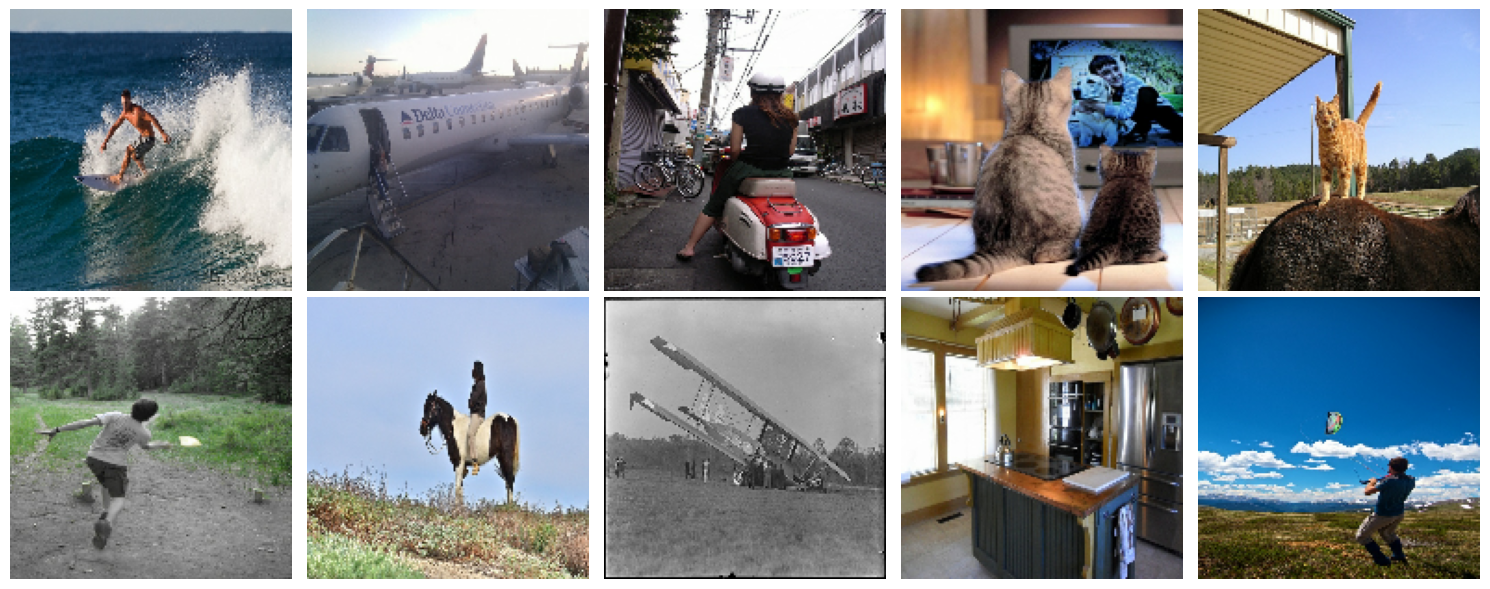

In [15]:
import matplotlib.pyplot as plt

def display_images(images, n=10):
    if n > len(images):
        n = len(images)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i in range(n):
        ax = axes[i//5, i%5]
        ax.imshow(images[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images(processed_images)
